# Linearity measure applied to fashion MNIST
 
## General definition

The model linearity module in alibi aims to provide a metric to measure how linear an ML model is. Linearity is defined based on how much the linear superposition of the model's outputs differs from the output of the same linear superposition of the inputs. 

Given $N$ input vectors $v_i$, $N$ real coefficients $\alpha_i$ and a predict function $\text{M}(v_i)$, the linearity of the predict function is defined as

$$L = \Big|\Big|\sum_i \alpha_i M(v_i) - M\Big(\sum_i \alpha_i v_i\Big) \Big|\Big| \quad \quad \text{If M is a regressor}$$

$$L = \Big|\Big|\sum_i \alpha_i \log \circ M(v_i) - \log \circ M\Big(\sum_i \alpha_i v_i\Big)\Big|\Big| \quad \quad \text{If M is a classifier}$$

## Alibi implementation
* Based on the general definition above, alibi calculates the linearity of a model in the neighboorhood of a given instance $v_0$. 

## Fashion MNIST data set

* We train a convolutional neural network to classify the images in the fashion MNIST dataset. 

* We investigate the correlation between the model's linearity associated to a certain instance and the class the instance belong to. 

* We also calculate the linearity measure for each internal layer of the CNN and show how linearity propagates through the model.

In [6]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from time import time

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)  # suppress deprecation messages

from alibi.confidence.model_linearity import linearity_measure, LinearityMeasure
from alibi.confidence.model_linearity import _infer_feature_range

import keras
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.models import Model
from keras.utils import to_categorical
from keras import backend as K

Using TensorFlow backend.


## Load data fashion mnist 
The fashion MNIST data set consists of 60000 images of shape $28 \times 28$ divided in 10 categories. Each category corresponds to a different type of clothing piece, such as "boots", "t-shirts", etc

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


Sample instance from the MNIST data set.


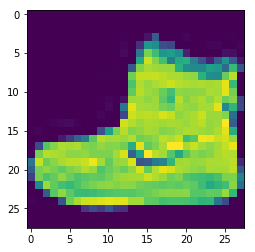

In [8]:
idx = 0
plt.imshow(x_train[idx])
print('Sample instance from the MNIST data set.')

In [9]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


## Convolutional neural network
Here we define and train a 2 layer convolutional neural network on the fashion MNIST data set.

### Define model

In [10]:
def model():
    x_in = Input(shape=(28, 28, 1), name='input')
    x = Conv2D(filters=64, kernel_size=2, padding='same', name='conv_1')(x_in)
    x = Activation('relu', name='relu_1')(x)
    x = MaxPooling2D(pool_size=2, name='maxp_1')(x)
    x = Dropout(0.3, name='drop_1')(x)
    
    x = Conv2D(filters=64, kernel_size=2, padding='same', name='conv_2')(x)
    x = Activation('relu', name='relu_2')(x)
    x = MaxPooling2D(pool_size=2, name='maxp_2')(x)
    x = Dropout(0.3, name='drop_2')(x)
    
    x = Flatten(name='flat')(x)
    x = Dense(256, name='dense_1')(x)
    x = Activation('relu', name='relu_3')(x)
    x = Dropout(0.5, name='drop_3')(x)
    x_out = Dense(10, name='dense_2')(x)
    x_out = Activation('softmax', name='softmax')(x_out)
    
    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return cnn

In [11]:
cnn = model()
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
relu_1 (Activation)          (None, 28, 28, 64)        0         
_________________________________________________________________
maxp_1 (MaxPooling2D)        (None, 14, 14, 64)        0         
_________________________________________________________________
drop_1 (Dropout)             (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 14, 14, 64)        16448     
_________________________________________________________________
relu_2 (Activation)          (None, 14, 14, 64)        0         
__________

### Training

In [12]:
cnn.fit(x_train, y_train, batch_size=64, epochs=5);

Epoch 1/5
60000/60000 [==============================] - 52s 874us/step - loss: 0.5514 - acc: 0.7992
Epoch 2/5
60000/60000 [==============================] - 47s 785us/step - loss: 0.3764 - acc: 0.8632
Epoch 3/5
60000/60000 [==============================] - 50s 832us/step - loss: 0.3331 - acc: 0.8793
Epoch 4/5
60000/60000 [==============================] - 56s 925us/step - loss: 0.3085 - acc: 0.8886
Epoch 5/5
60000/60000 [==============================] - 48s 793us/step - loss: 0.2890 - acc: 0.8941


## Linearity of each Layer 
Here we calculate the linearity of the model considering each layer as the output in turn. The values are averaged over 100 random instances sampled from the training set.

### Extract layers

In [13]:
inp = cnn.input
outs = {l.name: l.output for l in cnn.layers}
predict_fns = {name: K.function([inp], [out]) for name, out in outs.items()}

### Calculate linearity

In [14]:
# Infering feature ranges.
features_range = _infer_feature_range(x_test)

# Selecting random instances from training set.
rnd = np.random.randint(len(x_test) - 101, size=100)

In [15]:
lins_layers = {}
for name, l in predict_fns.items():
    if name != 'input':
        def predict_fn(x):
            layer = l([x])
            return layer[0]
        if name == 'softmax':
            lins_layers[name] = linearity_measure(predict_fn, x_test[rnd], feature_range=features_range,
                                                  agg='global', model_type='classifier', nb_samples=20)
        else:
            lins_layers[name] = linearity_measure(predict_fn, x_test[rnd], feature_range=features_range, 
                                                  agg='global', model_type='regressor', nb_samples=20)
lins_layers_mean = {k: v.mean() for k, v in lins_layers.items()}
S = pd.Series(data=lins_layers_mean)

Linearity measure in the locality of a given instance calculated taking as outputeach layer of a convolutional neural network trained on the fashion MNIST data set.The linearity measure of the first convolutional layer conv_1 is 0, as expected since convolutions are linear operations.The relu activation introduces non-linearity, which is increased by maxpooling. Dropout layers and flatten layers do no change the output at inference time so the linearity doesn't changeThe second convolutional layer conv_2 and the dense layers change the linearity even though they are linear operations.The softmax layer in red is obteined by inverting the softmax function. For more details see arxiv reference.


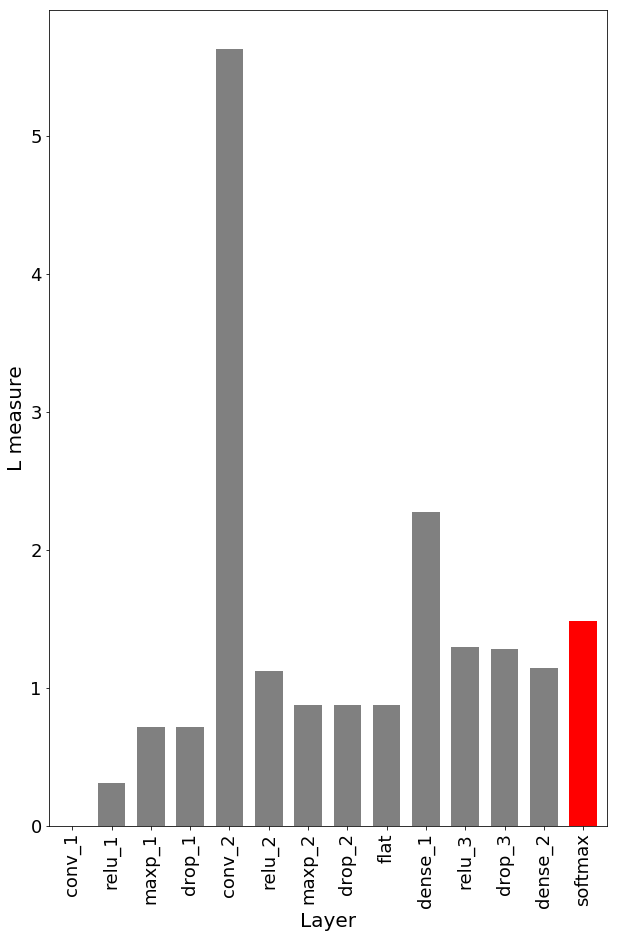

In [23]:
colors = ['gray' for l in S[:-1]]
colors.append('r')
ax = S.plot(kind='bar', linewidth=3, figsize=(10,), color=colors, width=0.7, fontsize=18)
ax.set_ylabel('L measure', fontsize=20)
ax.set_xlabel('Layer', fontsize=20)
print("{}".format("Linearity measure in the locality of a given instance calculated taking as output" + 
                  "each layer of a convolutional neural network trained on the fashion MNIST data set." + 
                  "The linearity measure of the first convolutional layer conv_1 is 0, as expected since convolutions are linear operations." + 
                  "The relu activation introduces non-linearity, which is increased by maxpooling. Dropout layers and flatten layers do no change the output at inference time so the linearity doesn't change" + 
                  "The second convolutional layer conv_2 and the dense layers change the linearity even though they are linear operations." + 
                  "The softmax layer in red is obteined by inverting the softmax function. For more details see arxiv reference."))
#print('Linearity measure in the locality of a given instance calculated taking as output each layer of a convolutional neural network trained on the fashion MNIST data set.')

Linearity measure in the locality of a given instance calculated taking as outputeach layer of a convolutional neural network trained on the fashion MNIST data set.The linearity measure of the first convolutional layer conv_1 is 0, as expected since convolutions are linear operations.The relu activation introduces non-linearity, which is increased by maxpooling. Dropout layers and flatten layers do no change the output at inference time so the linearity doesn't changeThe second convolutional layer conv_2 and the dense layers change the linearity even though they are linear operations. This effect is explained in arxiv reference


## Linearity and categories
Here we calculate the linearity averaged over all instances belonging to the same class, for each class.

In [60]:
class_groups = []
for i in range(10):
    y = y_test.argmax(axis=1)
    idxs_i = np.where(y == i)[0]
    class_groups.append(x_test[idxs_i])

In [89]:
def predict_fn(x):
    return cnn.predict(x)
lins_classes = []
t_0 = time()
for j in range(len(class_groups)):
    print('Calculating linearity for instances belonging to class {}'.format(j))
    class_group = class_groups[j]
    class_group = np.random.permutation(class_group)[:2000]
    t_i = time()
    lin = linearity_measure(predict_fn, class_group, feature_range=features_range, res=100, epsilon=0.04,
                                                  agg='global', model_type='classifier', nb_samples=20)
    t_i_1 = time() - t_i
    print('Run time for class {}: {}'.format(j, t_i_1))
    lins_classes.append(lin)
t_fin = time() - t_0
print('Total run time: {}'.format(t_fin))

Calculating linearity for instances belonging to class 0
Run time for class 0: 2.942014455795288
Calculating linearity for instances belonging to class 1
Run time for class 1: 3.0146484375
Calculating linearity for instances belonging to class 2
Run time for class 2: 2.811302423477173
Calculating linearity for instances belonging to class 3
Run time for class 3: 2.8430209159851074
Calculating linearity for instances belonging to class 4
Run time for class 4: 2.8134334087371826
Calculating linearity for instances belonging to class 5
Run time for class 5: 2.926085948944092
Calculating linearity for instances belonging to class 6
Run time for class 6: 2.9003241062164307
Calculating linearity for instances belonging to class 7
Run time for class 7: 2.914860248565674
Calculating linearity for instances belonging to class 8
Run time for class 8: 2.9462523460388184
Calculating linearity for instances belonging to class 9
Run time for class 9: 2.98537015914917
Total run time: 29.1052639484405

In [90]:
df = pd.DataFrame(data=lins_classes).T

Linearity measure distribution means for each class in the fashion MNIST data set.


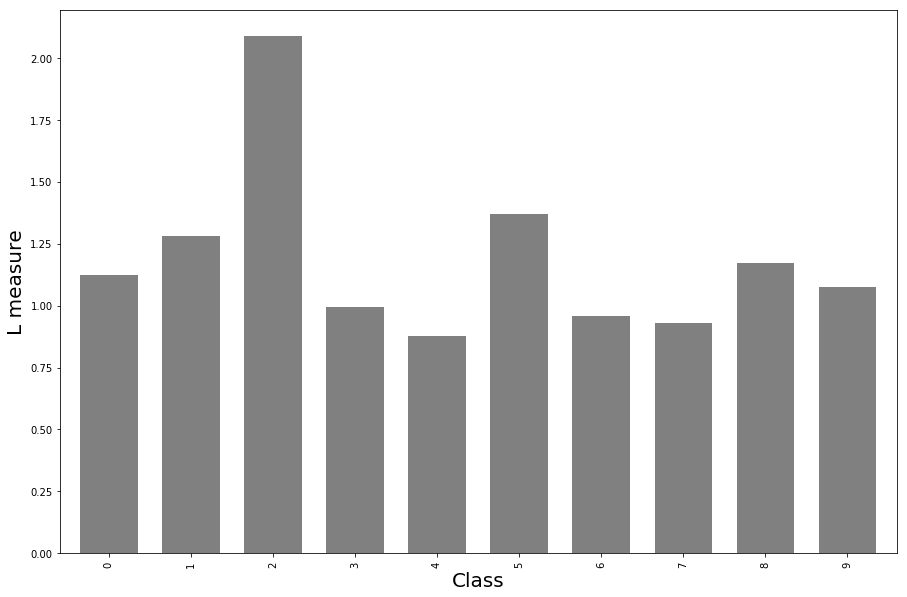

In [91]:
ax = df.mean().plot(kind='bar', linewidth=3, figsize=(15,10), color='gray', width=0.7, fontsize=10)
ax.set_ylabel('L measure', fontsize=20)
ax.set_xlabel('Class', fontsize=20)
print("Linearity measure distribution means for each class in the fashion MNIST data set.")

Linearity measure distributions for each class in the fashion MNIST data set.


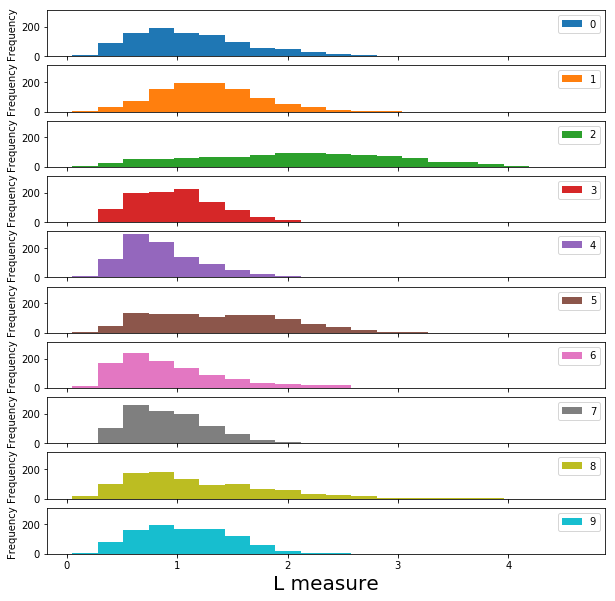

In [92]:
ax2 = df.plot(kind='hist', subplots=True, bins=20, figsize=(10,10), sharey=True)
for a in ax2:
    a.set_xlabel('L measure', fontsize=20)
#ax2.set_ylabel('F', fontsize=10)
print('Linearity measure distributions for each class in the fashion MNIST data set.')